In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
x_train_dir = os.path.join("./dataset/images/", 'training')
x_valid_dir = os.path.join("./dataset/images/", 'validation')
x_test_dir = os.path.join("./dataset/images/", 'testing')

y_train_dir = os.path.join("./dataset/annotations/", 'training')
y_valid_dir = os.path.join("./dataset/annotations/", 'validation')
y_test_dir = os.path.join("./dataset/annotations/", 'testing')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['void','keyway']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 1)
        
        # we only care about blue channel for label
        blue, green, red = cv2.split(mask)
        mask = cv2.merge([blue])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

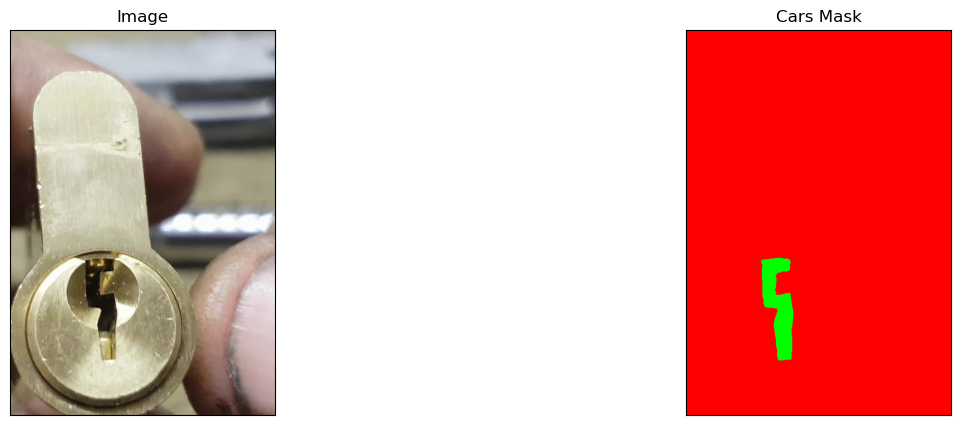

In [8]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['void','keyway'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    keyway_mask=mask.squeeze(),
)

In [7]:
import albumentations as A

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.9). Upgrade using: pip install --upgrade albumentations


In [13]:
# TODO: match
width = 384

def get_training_augmentation():
    train_transform = [
        A.ShiftScaleRotate(p=1),
        A.RandomBrightnessContrast(p=0.8),
        A.LongestMaxSize(int(width * 1.5)),
        A.PadIfNeeded(width, width),
        A.RandomCrop(width=width, height=width),
        
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.LongestMaxSize(int(width*1.5)),
        A.PadIfNeeded(width, width),
        A.RandomCrop(width=width, height=width),
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

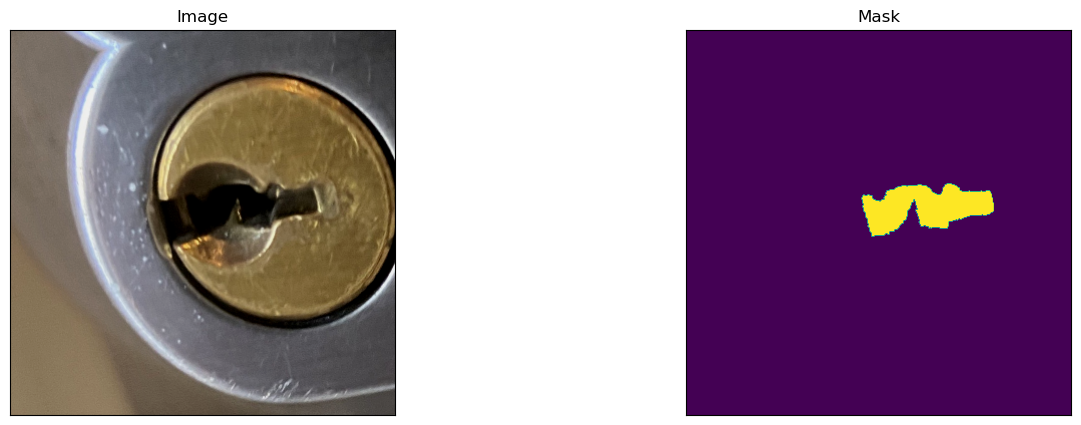

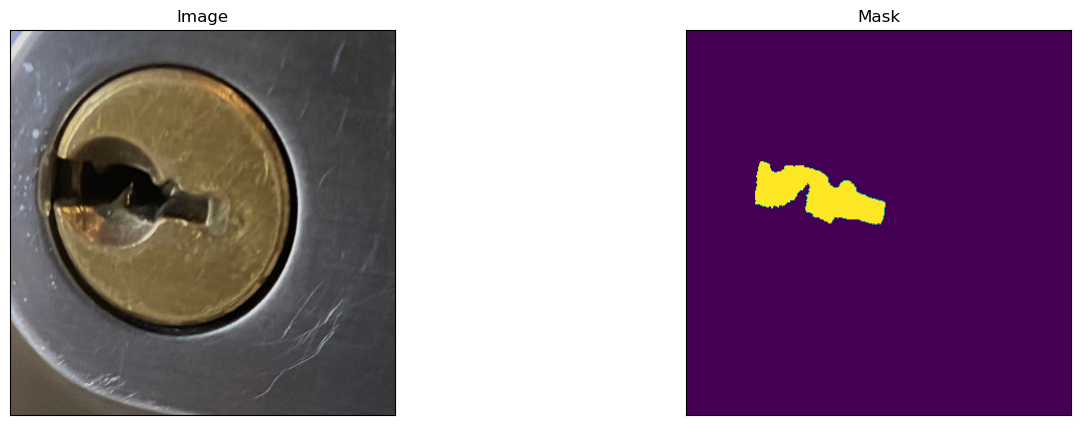

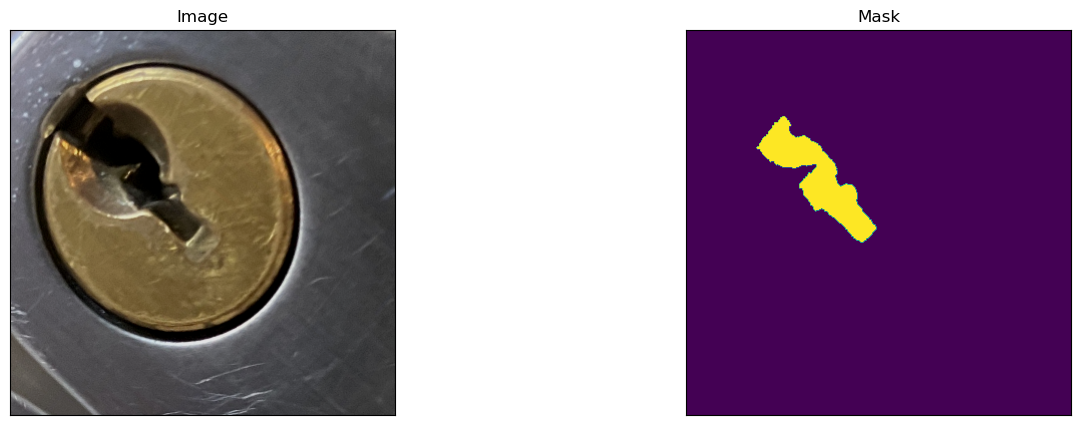

In [14]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['keyway'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [8]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['keyway']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=3)

In [19]:
import segmentation_models_pytorch.utils as utils

In [20]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [21]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [18]:
# train model for 20 epochs

max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|████████████████████████████████| 60/60 [00:20<00:00,  2.91it/s, dice_loss - 0.8129, iou_score - 0.5069]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████| 60/60 [00:17<00:00,  3.42it/s, dice_loss - 0.7493, iou_score - 0.7122]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████████| 60/60 [00:16<00:00,  3.54it/s, dice_loss - 0.6438, iou_score - 0.7116]

Epoch: 3
valid: 100%|████████████████████████████████| 60/60 [00:17<00:00,  3.44it/s, dice_loss - 0.5177, iou_score - 0.8133]
Model saved!

Epoch: 4
valid: 100%|████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s, dice_loss - 0.3853, iou_score - 0.8156]
Model saved!

Epoch: 5
valid: 100%|████████████████████████████████| 60/60 [00:17<00:00,  3.48it/s, dice_loss - 0.2934, iou_score - 0.7767]

Epoch: 6
valid: 100%|████████████████████████████████| 60/60 [00:17<00:00,  3.50it/s, dice_loss - 0.1757, iou_score - 0.8517]
Model saved!

Epoch: 7
valid: 100%|████████████████████████

In [9]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [22]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [23]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|███████████████████████████████████████████████████████| 57/57 [00:25<00:00,  2.24it/s, dice_loss - 0.06828, iou_score - 0.8957]


In [24]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

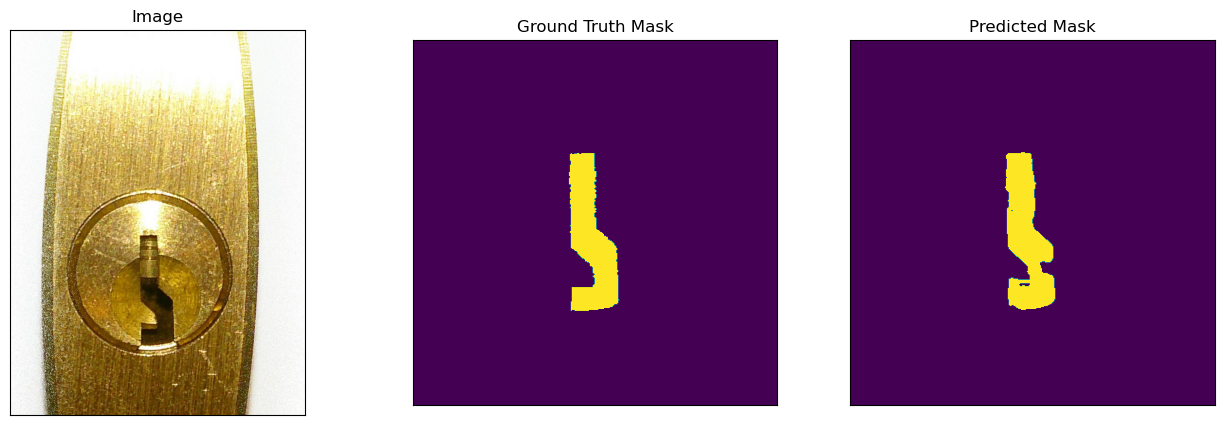

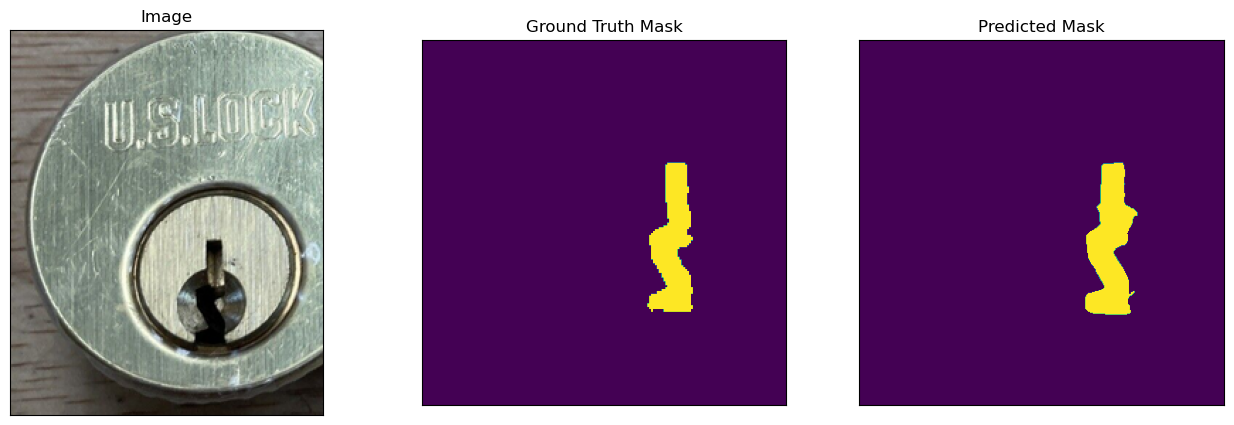

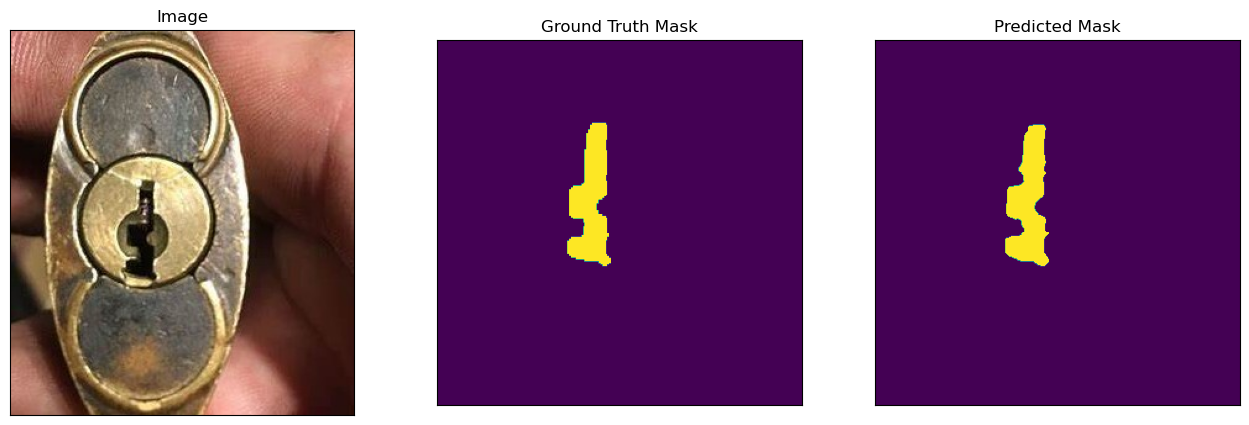

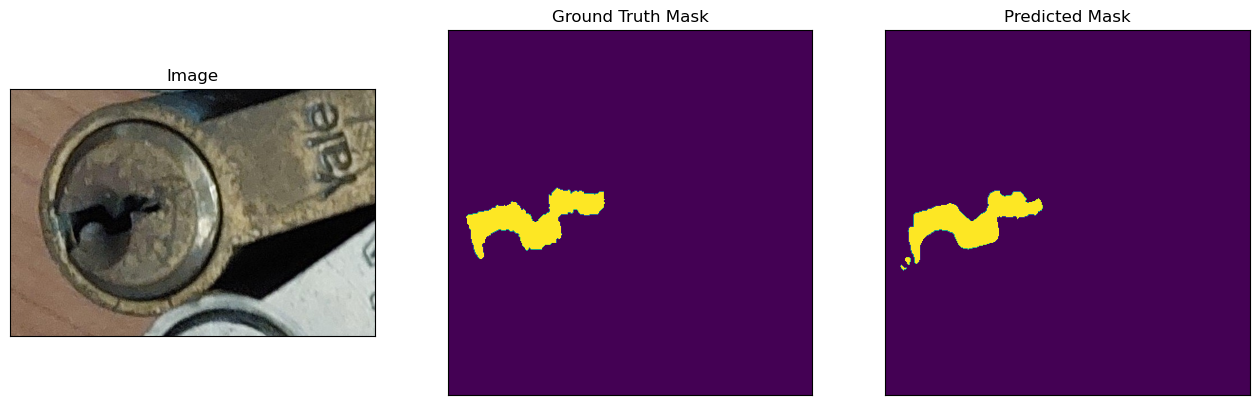

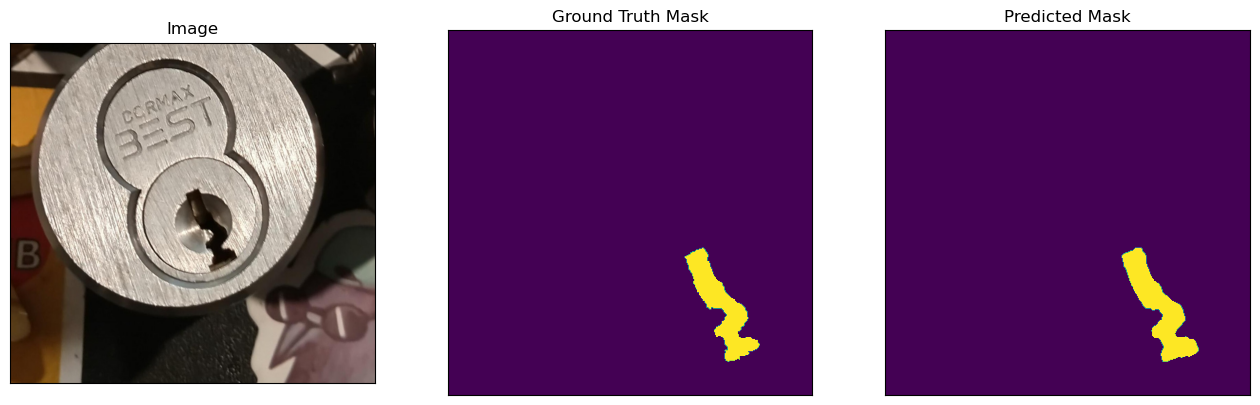

In [25]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [51]:
def crop_minAreaRect(img, rect):

   box = cv2.boxPoints(rect)
   box = np.int32(box)
   width, height = int(rect[1][0]), int(rect[1][1])

   src_pts = box.astype('float32')
   dst_pts = np.array([[0, height-1], [0, 0], [width-1, 0], [width-1, height-1]], dtype='float32')
   M = cv2.getPerspectiveTransform(src_pts, dst_pts)
   img_crop = cv2.warpPerspective(img, M, (width, height))

   return img_crop

In [57]:
img = cv2.imread("./refrence/test.png")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
 
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

for i, c in enumerate(contours):
    area = cv2.contourArea(c)

    if area < 10 or area > (bw.shape[0] * bw.shape[1] * 0.9):
        continue

    print(area)
    rect = cv2.minAreaRect(c)
    img = crop_minAreaRect(img, rect)
  
# Save the output image to the current directory
img = cv2.resize(img, (512,512))
cv2.imwrite("test.png", img)

138812.5


True